# Simple Jax (haiku) NN from Scratch

Haiku is a deep learning library designed for Jax. It provides a set of tools that make defining models and handling initialization and paramater updates much easier. In this notebook we show how to use Haiku to train a simple neural network.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import haiku as hk
import jax
from jax import random
from jax import nn
from jax import vmap
from jax import grad

In [2]:
data_df = pd.read_csv('./digit-recognizer/train.csv')

In [3]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

Our NN will have a simple two-layer architecture. Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $A^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $A^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.


**Forward propagation**

Input Layer:    
$$X = A^{[0]}$$

First Hidden Layer:
$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$

Second Hidden Layer:
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

Loss Function (Categorical Cross Entropy):  
$$L(y, a^{[2]}) = -\sum_{j = 1}^{C}y_{j} \cdot\ log(a^{[2]})$$ 
C is the number of classes, which is 10 in this case. 

Cost Function:
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} L(y^{i}, a^{[2](i)})$$ 
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} \sum_{j = 1}^{C}y^{i}_{j}\cdot\log(a^{[2](i)})$$ 
The cost function is the average of the losses over all the samples.

Derivatives:    
For detailed derivation of $dZ^{[2]}$ see: [derivation-of-categorical-cross-entropy-loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)    
For more details on the rest of the derivations see: [backpropagation-intuition](https://www.youtube.com/watch?v=yXcQ4B-YSjQ&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=34&ab_channel=DeepLearningAI)
$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[1]}}$$

**Gradient Descent (parameter updates)**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

The layers and activation functions can now be defined using Haiku's functions. No need to explicitly specify the weights and biases of each layer.

In [100]:
def _forward_fn(x):
    mlp = hk.Sequential([
        hk.Linear(10), jax.nn.relu,
        hk.Linear(10), jax.nn.softmax
    ])
    return mlp(x)

The Haiku model above is an object, not a pure function, which is required for Jax's. So the model is first transformed using the hk.transform method.

In [101]:
forward_fn = hk.transform(_forward_fn)

The models layers shown below, are the same as used in previous notebooks.

In [102]:
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)

initial_params = forward_fn.init(rng=rng_key, x=dummy_x)

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape, initial_params[layer_name]["b"].shape))

linear
Weights : (784, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)



The model can process a batch of any size.

In [103]:
preds = forward_fn.apply(initial_params, rng_key, X_train[:5])
print(preds)

[[0.128051   0.08334645 0.1371376  0.11183916 0.08015057 0.09683434
  0.08505183 0.09501389 0.09942932 0.08314574]
 [0.11674449 0.05540307 0.14186898 0.09364638 0.0625442  0.08272201
  0.05157936 0.14554046 0.15974481 0.09020625]
 [0.09376369 0.09093273 0.11680041 0.12771602 0.09921065 0.12666576
  0.08326413 0.09241117 0.0874539  0.08178152]
 [0.0983962  0.07797649 0.15492453 0.1244545  0.06791054 0.11238939
  0.06410503 0.0958218  0.10446892 0.09955262]
 [0.10721549 0.09586134 0.1157705  0.10063749 0.08447137 0.09433784
  0.09176547 0.10286564 0.10602225 0.10105269]]


The forward pass performed in the loss function now needs the .apply method. The explicit weights, biases and gradients have been replaced by params and grads in the update_params function. This saves a lot of code on more complex models.

In [104]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    A2 = forward_fn.apply(params, rng_key, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


The initialization function has been removed since Haiku handles the initialization using the .init method.

In [106]:
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng=rng, x=X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = forward_fn.apply(params, rng, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return params

In [107]:
params = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[1 1 3 ... 1 1 5] [0 0 0 ... 1 8 6]
0.16109756
Iteration:  10
[0 8 0 ... 1 1 1] [0 0 0 ... 1 8 6]
0.36163414
Iteration:  20
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.60007316
Iteration:  30
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.6927317
Iteration:  40
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.72697556
Iteration:  50
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.7529512
Iteration:  60
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.7769268
Iteration:  70
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.79580486
Iteration:  80
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.8119268
Iteration:  90
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.82373166
Iteration:  100
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.83385366
Iteration:  110
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.841878
Iteration:  120
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.8484878
Iteration:  130
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.85499996
Iteration:  140
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.85975605
Iteration:  150
[0 0 0 ... 1 3 6] [0 0 0 ... 1 8 6]
0.8639024
Iteration: 

In [96]:
def make_predictions(X, W1, b1, W2, b2):
    A2 = batched_forward(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


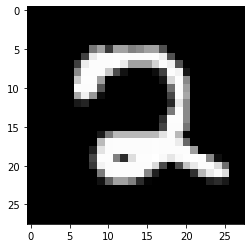

Prediction:  [0]
Label:  0


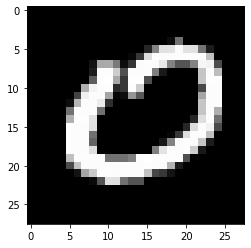

Prediction:  [8]
Label:  8


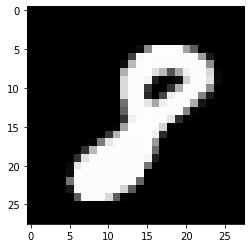

Prediction:  [1]
Label:  1


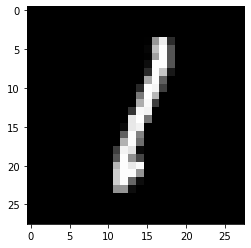

In [97]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [98]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

[3 6 8 8 3 4 5 7 1 9 5 4 5 2 1 7 0 4 1 7 0 8 9 9 4 9 1 7 7 5 2 7 9 0 2 3 6
 7 9 6 9 3 9 4 7 9 6 6 6 4 2 7 4 4 1 6 0 6 7 7 1 1 7 1 4 1 6 2 9 3 6 2 2 0
 2 6 7 3 1 0 6 5 3 1 3 3 6 3 9 2 2 1 2 6 1 0 1 9 7 5 1 9 9 4 8 7 6 2 0 6 3
 2 2 6 3 8 7 5 0 6 5 4 5 1 1 0 1 9 5 6 4 5 5 8 1 4 9 0 2 2 3 8 1 7 7 2 4 2
 1 3 8 6 3 7 9 4 7 9 5 7 9 7 0 0 0 7 9 4 1 7 2 4 8 8 8 0 3 7 9 8 5 8 9 6 5
 8 1 5 3 4 1 4 2 7 0 6 3 0 5 7 6 7 3 7 9 1 2 7 2 1 0 1 1 9 7 7 1 2 3 8 8 4
 2 4 8 4 0 2 8 4 3 1 9 4 4 6 6 6 0 6 6 9 7 7 9 7 9 7 4 7 3 7 6 4 2 0 7 8 8
 6 7 5 1 2 7 5 8 0 2 2 6 8 8 6 0 3 3 2 0 6 3 9 1 1 3 2 8 3 9 3 0 5 9 0 1 3
 7 6 4 8 6 5 5 3 7 0 8 2 9 1 1 0 4 8 2 6 0 7 0 1 8 9 1 4 7 9 7 9 4 7 2 6 0
 2 5 7 3 6 6 2 1 3 2 3 6 8 0 0 1 8 4 1 9 1 8 1 0 6 2 5 7 4 0 0 0 1 1 6 1 4
 7 7 3 0 1 0 4 3 0 7 6 5 9 2 7 8 9 0 6 1 8 6 0 9 8 0 1 8 9 6 3 8 4 1 0 2 6
 5 6 7 7 8 4 1 4 3 7 9 0 3 0 8 3 3 1 3 9 3 4 2 1 0 1 0 6 6 2 3 7 7 7 6 7 0
 5 4 7 4 1 2 4 2 7 1 7 9 7 1 5 0 1 1 7 2 7 1 4 2 6 4 5 5 7 5 3 1 7 4 8 6 0
 5 3 0 3 9 4 3 6 2 9 6 1 

DeviceArray(0.83900005, dtype=float32)

No loss in accuracy during training or inferencing compared to other methods.

### Conclusion

Haiku provides powerful tools that make defining model architecture and intialization simple. As shown in this notebook, this saves a lot of time and complexity in the code.